In [1]:
import os

import pandas as pd
import numpy as np
import polars as pl
from datetime import timedelta

from scipy.sparse import csr_matrix
from scipy.sparse import hstack
import hnswlib

import pyarrow.parquet as pq

from scipy.sparse import csr_matrix
import numpy as np

from tqdm.auto import tqdm

c:\Users\glebp\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DATA_dir = "data"

df_click_stream = pd.read_parquet(f"{DATA_dir}\clickstream.pq")
df_test_users = pd.read_parquet(f"{DATA_dir}\test_users.pq")
df_cat_features = pl.read_parquet(f"{DATA_dir}\cat_features.pq")
df_text_features =  pl.read_parquet(f"{DATA_dir}\text_features.pq")
df_event = pl.read_parquet(f"{DATA_dir}\events.pq")

In [205]:
df_click_stream = df_click_stream.drop_duplicates(subset=['cookie', 'item', 'node'])

# Feature Extraction

In [ ]:
#for df_click_stream.event_date
df_click_stream['event_date'] = pd.to_datetime(df_click_stream.event_date)
datetime = pd.to_datetime(df_click_stream.event_date)

df_click_stream['month'] = datetime.dt.month
df_click_stream['day'] = datetime.dt.day
df_click_stream['hour'] = datetime.dt.hour

def to_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 22:
        return 'evening'
    else:
        return 'night'
    
month_to_month = {1:'january', 2:'february'}

df_click_stream['time_of_day'] = df_click_stream['hour'].apply(to_time_of_day)
df_click_stream['month_of_year'] = df_click_stream['month'].apply(lambda x: month_to_month[x])
df_click_stream['cookie'] = df_click_stream['cookie'].astype(int)

df_click_stream = df_click_stream.drop(['hour', 'month'], axis=1)    

df_click_stream = pd.get_dummies(data = df_click_stream, columns=['time_of_day', 'month_of_year'], dtype=int)

In [208]:
df_cat_features = df_cat_features.join(df_text_features, on='item', how='left').drop(['clean_params'])

In [209]:
df_clickstream = pl.from_pandas(df_click_stream)
df_clickstream.head()

cookie,item,event,event_date,platform,surface,node,day,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night,month_of_year_february,month_of_year_january
i64,i64,i64,datetime[ns],i64,i64,u32,i32,i64,i64,i64,i64,i64,i64
0,19915558,17,2025-02-05 02:30:59,3,2,115659,5,0,0,0,1,1,0
0,2680232,17,2025-01-24 21:16:57,3,2,115829,24,0,1,0,0,0,1
1,4247649,17,2025-01-29 23:00:58,2,2,7,29,0,0,0,1,0,1
1,2171135,17,2025-01-17 19:23:29,2,2,214458,17,0,1,0,0,0,1
1,6830678,17,2025-02-09 13:17:03,2,2,15,9,1,0,0,0,1,0


# PREPARE TRAIN EVAL

In [ ]:
EVAL_DAYS_TRESHOLD = 14

treshhold = df_clickstream['event_date'].max() - timedelta(days=EVAL_DAYS_TRESHOLD)

df_train = df_clickstream.filter(df_clickstream['event_date']<= treshhold)
df_eval = df_clickstream.filter(df_clickstream['event_date']> treshhold)

df_eval = df_eval.join(df_train, on=['cookie', 'node'], how='anti')

In [ ]:
df_eval = df_eval.filter(
    pl.col('event').is_in(df_event.filter(pl.col('is_contact')==1)['event'].unique()))

df_train = df_train.filter(
    pl.col('event').is_in(df_event.filter(pl.col('is_contact')==1)['event'].unique()))

In [215]:
df_eval = df_eval.filter(
        pl.col('cookie').is_in(df_train['cookie'].unique())
    ).filter(
        pl.col('node').is_in(df_train['node'].unique())
    )

C:\Users\glebp\AppData\Local\Temp\ipykernel_3444\3923218121.py:1: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  df_eval = df_eval.filter(
C:\Users\glebp\AppData\Local\Temp\ipykernel_3444\3923218121.py:3: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  ).filter(


In [216]:
df_eval = df_eval.unique(['cookie', 'node'])
df_train = df_train.unique(['cookie', 'node'])

df_train = df_train.drop(['item','event_date'])
df_eval = df_eval.drop(['item','event_date'])

## Vector Store of Items

In [221]:
a = df_click_stream.groupby('node')['item'].apply(lambda x: x.mode().iloc[0]).reset_index()
a = pl.from_pandas(a)
a = a.join(df_text_features, on='item', how='left').drop('item')

In [222]:
node2title = {}
for i in range(len(a)):
    row = a.row(i)
    node = row[0]
    title_projection = row[1]
    node2title[node] = title_projection

In [223]:
data = a['title_projection'].to_list()
num_elements = len(a)

dim = len(data[0])
ids = a['node'].to_list()

In [102]:
p = hnswlib.Index(space = 'l2', dim = dim)

p.init_index(max_elements = num_elements, ef_construction = 200, M = 32)
p.add_items(data, ids)

p.set_ef(400) 

In [ ]:
def get_Top150(query_vec):
    candidates, distances = p.knn_query(query_vec, k=150)
    return candidates

In [89]:
def get_label(cookie, node):
    querry_vec = node2title[node]
    candidates = get_Top150(querry_vec)[0]
    nodes = df_train.filter(pl.col('cookie') == cookie)['node'].to_list()

    result = [1 if node in nodes else 0 for node in candidates ]
    item_features = [node2title[node] for node in candidates]

    return result, item_features

In [246]:
def get_features(candidates):
    return [node2title[node] for node in candidates]

# Model Training

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [91]:
label_item_feat = {}

class RunkingDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.cookie = data['cookie']
        self.node = data['node']
        

        super().__init__()

    def __getitem__(self, idx):
        name = str(self.cookie[idx])+ str(self.node[idx])

        if (label_item_feat.get(name)):
            label, item_features = label_item_feat.get(name)
        else: 
            label, item_features = get_label(self.cookie[idx], self.node[idx])
            label_item_feat[name] = label, item_features

        context_features = self.data.drop('cookie', 'node')

        return {
            'label': torch.FloatTensor(label).to(device),
            'context_features': torch.FloatTensor(context_features.row(idx)).to(device),
            'item_features': torch.FloatTensor(item_features).to(device)
        }

    def __len__(self):
        return len(self.cookie)


In [92]:
train_dataset = RunkingDataset(df_train)
eval_dataset = RunkingDataset(df_eval)

BATCH_SIZE = 64

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE*2, shuffle=False)

In [104]:
def train_one_epoch(model, criterion, optimizer, train_loader, eval_loader):

    train_loss = []
    for i,batch in enumerate(tqdm(train_loader)):
        model.train()
        optimizer.zero_grad()
        outp = model(batch['item_features'], batch['context_features'])

        loss = criterion(outp, batch['label'])
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    epoch_val_loss = []
    for i, batch in enumerate(tqdm(eval_loader)):
        model.eval()
        outp = model(batch['item_features'], batch['context_features'])
        loss = criterion(outp, batch['label'])
    
        epoch_val_loss.append(loss.item())

    return model, sum(train_loss)/len(train_loss), sum(epoch_val_loss)/len(epoch_val_loss)

def train_model(model, criterion, optimizer, train_loader, eval_loader, num_epochs):
    train_losses = []
    eval_losses = []

    for epoch in range(1,num_epochs+1):
        model, train_loss, eval_loss = train_one_epoch(model, criterion, optimizer, train_loader, eval_loader)

        train_losses.append(train_loss)
        eval_losses.append(eval_loss)

        print(f"Epoch:{epoch}. Train Loss:{train_loss}. Eval Loss:{eval_loss}.")

        model_dir = 'model_epochs'
        torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-{}.pth'.format(epoch)))
        
    return model,train_losses, eval_losses


In [382]:
from Model.model import RunkedModel

num_item_features = train_dataset[0]['item_features'][0].size(0)
num_context_features = train_dataset[0]['context_features'].size(0)

model = RunkedModel(num_item_features, num_context_features).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 3e-4)

In [105]:
model, train_loss, eval_loss = train_model(model, criterion, optimizer, train_dataloader, eval_dataloader, 10)

100%|██████████| 287/287 [01:44<00:00,  2.74it/s]


Epoch:1. Train Loss:0.03343945613344386. Eval Loss:0.011534711715963245.


100%|██████████| 287/287 [00:49<00:00,  5.85it/s]


Epoch:2. Train Loss:0.02434103446669023. Eval Loss:0.01521778904641443.


100%|██████████| 287/287 [00:47<00:00,  6.07it/s]


Epoch:3. Train Loss:0.021854397782316105. Eval Loss:0.017364910229365586.


100%|██████████| 287/287 [00:48<00:00,  5.90it/s]


Epoch:4. Train Loss:0.020587481053332614. Eval Loss:0.019300841791263235.


100%|██████████| 287/287 [00:59<00:00,  4.79it/s]


Epoch:5. Train Loss:0.019894063954930197. Eval Loss:0.01977564213401557.


100%|██████████| 287/287 [00:58<00:00,  4.90it/s]


Epoch:6. Train Loss:0.019360188961765924. Eval Loss:0.018785832456283867.


100%|██████████| 287/287 [00:59<00:00,  4.85it/s]


Epoch:7. Train Loss:0.019072352338061788. Eval Loss:0.021852352737549704.


100%|██████████| 287/287 [00:50<00:00,  5.72it/s]


Epoch:8. Train Loss:0.018819448571459185. Eval Loss:0.020492427615701945.


100%|██████████| 287/287 [00:53<00:00,  5.40it/s]


Epoch:9. Train Loss:0.01870984558419586. Eval Loss:0.023120239831325485.


100%|██████████| 287/287 [00:49<00:00,  5.83it/s]

Epoch:10. Train Loss:0.0183991984556337. Eval Loss:0.022432950555707105.


In [106]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

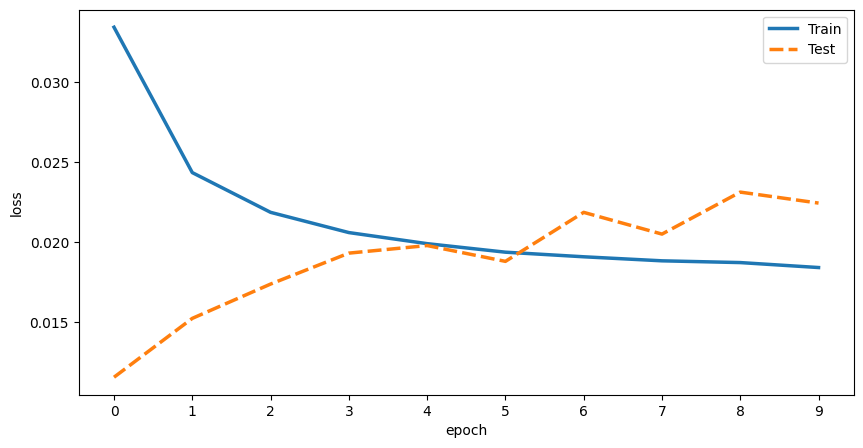

In [ ]:
res_training = pd.DataFrame({'Train': train_loss, 'Test': eval_loss})

plt.figure(figsize=(10,5))
fig_acc = sns.lineplot(data=res_training, linewidth=2.5)
fig_acc.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
fig_acc.set(xlabel='epoch', ylabel='loss')
plt.show()

In [ ]:
def get_preds(model, context, node, k):
    candidates = get_Top150(node2title[node])[0]
    
    item_features = torch.FloatTensor(get_features(candidates)).unsqueeze(0)
    context_features = torch.FloatTensor(context).unsqueeze(0)

    model.eval()
    preds = list(model.to('cpu')(item_features, context_features).argsort()[0])
    return [int(candidates[int(idx)]) for idx in preds[-k:]]


def recall_at(df_true, model, k=40):

    num_in_k = 0
    total = 0

    for i in range(len(df_true)):
        row = df_true[i]

        cookie = row['cookie'][0]
        node = row['node'][0]
        context = row.drop(['cookie', 'node']).row(0)

        true_nodes = df_true.filter(pl.col('cookie') == cookie)['node'].to_list()[1:]
        preds_nodes = get_preds(model, context, node, k)

        for i in (true_nodes):
            for j in (preds_nodes):
                if i == j:
                    num_in_k += 1
            total += 1
    
    return num_in_k/total
    

In [ ]:
for epoch in range(5, 8):
    model.load_state_dict(torch.load(f"C:\daata\gfd\model_epochs\epoch-{epoch}.pth", weights_only=True))
    print(f"Recall for {epoch} epoch: {recall_at(df_eval, model)}")

Recall for 5 epoch: 0.18949955537990316
Recall for 6 epoch: 0.19089516846161446
Recall for 7 epoch: 0.19133978855844284
